In [1970]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier

import catboost
from catboost import CatBoostClassifier

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import f1_score

/kaggle/input/startups-operations-close-predictions-m-1-41-ds/kaggle_startups_train_28062024.csv
/kaggle/input/startups-operations-close-predictions-m-1-41-ds/kaggle_startups_sample_submit_28062024.csv
/kaggle/input/startups-operations-close-predictions-m-1-41-ds/kaggle_startups_test_28062024.csv


In [1971]:
import warnings

# Отключаем FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# Отключаем научную нотацию в pandas
pd.options.display.float_format = '{:,.0f}'.format

In [1972]:
# Функция загрузки файлов
def load_csv(path):
    try:
        df = pd.read_csv(path)
        print(path, ' загружен успешно.')
        return df
    except Exception as e:
        print(f'Ошибка при загрузке {path}: {e}')
        return None

In [1973]:
# Функция приведения типа к дате
def to_datetime64(df, cols):
    for col in cols:
        df[col] = pd.to_datetime(df[col])

In [1974]:
df_train = load_csv('/kaggle/input/startups-operations-close-predictions-m-1-41-ds/kaggle_startups_train_28062024.csv')

/kaggle/input/startups-operations-close-predictions-m-1-41-ds/kaggle_startups_train_28062024.csv  загружен успешно.


In [1975]:
X_test = load_csv('/kaggle/input/startups-operations-close-predictions-m-1-41-ds/kaggle_startups_test_28062024.csv')

/kaggle/input/startups-operations-close-predictions-m-1-41-ds/kaggle_startups_test_28062024.csv  загружен успешно.


In [1976]:
RANDOM_STATE = 42

# Устанавливаем начальную дату
START_DATE = pd.to_datetime('2018-01-01')

## Работаем с df_train

In [1977]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB
None


In [1978]:
display(df_train.head())

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,"828,626",operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,"42,935,019",operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,"35,456,381",operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,"22,250,000",operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


In [1979]:
print(df_train.isna().sum())

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64


### Обрабатываем названия

In [1980]:
# Приведем все названия к Title Case и удалим дубли
df_train['name'] = df_train['name'].fillna('unknown')
df_train['name'] = df_train['name'].str.title()
print('Дублей в названиях (было): ', df_train['name'].duplicated().sum())

df_train = df_train[df_train.duplicated(subset='name', keep=False) == False]
print('Дублей в названиях (стало): ', df_train['name'].duplicated().sum())

Дублей в названиях (было):  43
Дублей в названиях (стало):  0


### Обрабатываем категории

In [1981]:
df_train['category_list'] = df_train['category_list'].fillna('unknown')

# Посчитаем количество уникальных комбинаций
print('Количество уникальных комбинаций категорий:', len(df_train['category_list'].unique()))

# Посчитаем количество уникальных категорий
all_categories = df_train['category_list'].str.split('|').explode().unique()
print('Количество уникальных категорий:', len(all_categories))

Количество уникальных комбинаций категорий: 22064
Количество уникальных категорий: 855


In [1982]:
# Отобразим строки, где количество категорий равно максимальному
max_categories_per_record = df_train['category_list'].str.split('|').apply(len).max()
print('Максимальное количество категорий в одной записи: ', max_categories_per_record)

max_category_row = df_train[df_train['category_list'].str.split('|').apply(len) == max_categories_per_record]
display(max_category_row)

# Отобразим полное содержание категоирий для этих строк
pd.set_option('display.max_colwidth', None)
display(max_category_row['category_list'])
pd.reset_option('display.max_colwidth')

Максимальное количество категорий в одной записи:  40


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
42849,Zealr,Analytics|Application Platforms|App Marketing|...,"7,500",operating,USA,CA,Ontario - Inland Empire,Yorba Linda,1,2015-01-20,2015-08-18,2015-08-18,NaN


42849    Analytics|Application Platforms|App Marketing|Apps|Brand Marketing|Business Analytics|Content|Content Creators|Content Delivery|CRM|Curated Web|Data Integration|Data Visualization|Email|Email Marketing|Enterprise Application|Enterprise Software|Facebook Applications|Group SMS|Messaging|Mobile Analytics|Mobile Software Tools|Predictive Analytics|Private Social Networking|Productivity|Productivity Software|Professional Networking|Sales and Marketing|Sales Automation|Salesforce Killers|SMS|Social CRM|Social Media|Social Media Marketing|Social Network Media|Software|Supply Chain Management|Technology|Text Analytics|Twitter Applications
Name: category_list, dtype: object

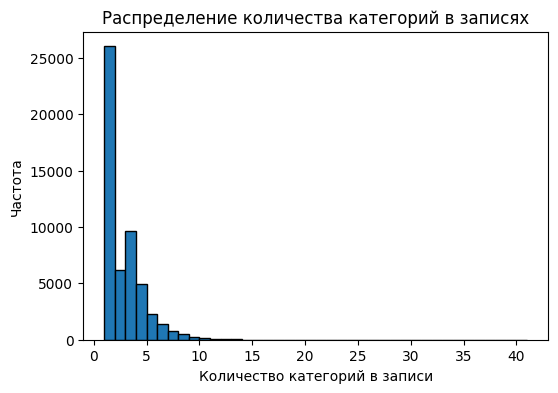

Количество записей с более чем 10 категориями: 210


In [1983]:
# Построим гистограмму распределения количества категорий в каждой записи
category_counts = df_train['category_list'].str.split('|').apply(len)

plt.figure(figsize=(6, 4))
plt.hist(category_counts, bins=range(1, category_counts.max() + 2), edgecolor='black')
plt.xlabel('Количество категорий в записи')
plt.ylabel('Частота')
plt.title('Распределение количества категорий в записях')
plt.show()

print('Количество записей с более чем 10 категориями:', 
      len(df_train[df_train['category_list'].str.split('|').apply(len) > 10])
)

# Заменим значения category_list с более чем 10 категориями на 'multi'
df_train.loc[df_train['category_list'].str.split('|').apply(len) > 10, 'category_list'] = 'multi'

In [1984]:
# Функция для приведения каждой категории к title case
def to_title_case(category_list):
    # Разбиваем строку по '|', приводим каждую категорию к title case, объединяем обратно
    title_cased_categories = [cat.title() for cat in category_list.split('|')]
    return '|'.join(title_cased_categories)

# Применяем функцию ко всем строкам в колонке 'category_list'
df_train['category_list'] = df_train['category_list'].apply(to_title_case)

In [1985]:
# Функция для удаления дубликатов в списке категорий
def remove_duplicates(category_list):
    # Разбиваем строку по символу '|', превращаем в множество (чтобы убрать дубликаты), и снова объединяем через '|'
    unique_categories = set(category_list.split('|'))
    return '|'.join(unique_categories)

# Применяем функцию ко всем строкам в колонке 'category_list'
df_train['category_list'] = df_train['category_list'].apply(remove_duplicates)

In [1986]:
# Разделяем категории на однословные и многословные
one_word_categories = [cat for cat in all_categories if ' ' not in cat]
multi_word_categories = [cat for cat in all_categories if ' ' in cat]

# Создаем словарь для замены: ключи — однословные категории, значения — многословные категории
replacement_dict = {}

for one_word in one_word_categories:
    # Ищем многословные категории, которые содержат однословную категорию
    matching_multi_words = [multi_word for multi_word in multi_word_categories if one_word in multi_word.split()]
    
    # Если есть совпадения, добавляем в словарь первый найденный многословный вариант
    if matching_multi_words:
        replacement_dict[one_word] = matching_multi_words[0]  # или можно добавить все совпадения, если нужно

# Функция для замены категорий
def replace_single_word_categories(category_list):
    categories = category_list.split('|')
    return '|'.join([replacement_dict.get(cat, cat) for cat in categories])

# Применяем замену к колонке 'category_list'
df_train['category_list'] = df_train['category_list'].apply(replace_single_word_categories)

In [1987]:
# Выводим результат
print('Количество уникальных комбинаций категорий:', len(df_train['category_list'].unique()))

# Посчитаем количество уникальных категорий
all_categories = df_train['category_list'].str.split('|').explode().unique()
print('Количество уникальных категорий:', len(all_categories))

# Выведем примеры категорий
print('')
for category in df_train['category_list'].unique()[:50]:
    print(category)

Количество уникальных комбинаций категорий: 21578
Количество уникальных категорий: 780

Online Reservations|Restaurants
Medical Devices|Medical Devices|Semiconductor Manufacturing Equipment
Biotechnology and Semiconductor
Health Care
Semiconductor Manufacturing Equipment
Mobile Commerce
Social Media Monitoring|Social Crm|Enterprise Software|Business Analytics|Business Analytics
Enterprise Software
Semiconductors
Clean Technology
Unknown
Clean Technology|Wine And Spirits|Nanotechnology
Customer Service|Retail Technology|Content Delivery
Enterprise Software|Computers|Cloud Data Services|Private Social Networking|Business Analytics
Banking|Loyalty Programs|Finance Technology
Messaging
Consumers
Social Media|Photo Sharing|Generation Y-Z
College Recruiting|Enterprise Software|Enterprise Software|College Recruiting|Social Recruiting|Saas
Mobile Payments|Financial Services|Finance Technology
Enterprise Software|Semiconductor Manufacturing Equipment|Enterprise Resource Planning|Cloud Computing

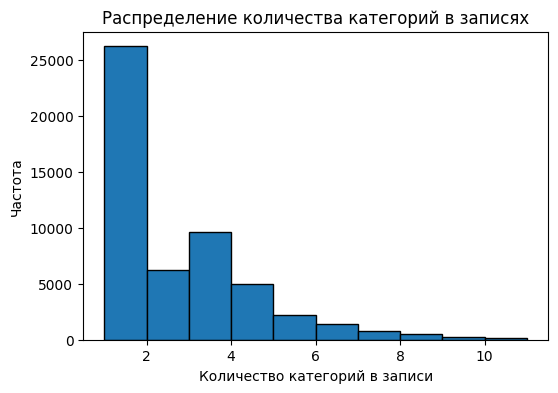

In [1988]:
# Обновим гистограмму распределения количества категорий в каждой записи
category_counts = df_train['category_list'].str.split('|').apply(len)

plt.figure(figsize=(6, 4))
plt.hist(category_counts, 
         bins=range(1, category_counts.max() + 2), 
         edgecolor='black')
plt.xlabel('Количество категорий в записи')
plt.ylabel('Частота')
plt.title('Распределение количества категорий в записях')
plt.show()

In [1989]:
'''
categories_expanded = df_train['category_list'].str.split('|', expand=True)

# Переименовываем колонки
categories_expanded.columns = [f'category_{i+1}' for i in range(categories_expanded.shape[1])]

# Объединяем с исходным DataFrame
df_train = pd.concat([df_train, categories_expanded], axis=1)

# Удаляем исходную колонку 'category_list' (по желанию)
df_train.drop(columns=['category_list'], inplace=True)

cats = ['category_1',
       'category_2',
       'category_3',
       'category_4',
       'category_5',
       'category_6',
       'category_7',
       'category_8',
       'category_9',
       'category_10'
]
       
df_train[cats] = df_train[cats].fillna('unknown')
print(df_train.info())
'''

"\ncategories_expanded = df_train['category_list'].str.split('|', expand=True)\n\n# Переименовываем колонки\ncategories_expanded.columns = [f'category_{i+1}' for i in range(categories_expanded.shape[1])]\n\n# Объединяем с исходным DataFrame\ndf_train = pd.concat([df_train, categories_expanded], axis=1)\n\n# Удаляем исходную колонку 'category_list' (по желанию)\ndf_train.drop(columns=['category_list'], inplace=True)\n\ncats = ['category_1',\n       'category_2',\n       'category_3',\n       'category_4',\n       'category_5',\n       'category_6',\n       'category_7',\n       'category_8',\n       'category_9',\n       'category_10'\n]\n       \ndf_train[cats] = df_train[cats].fillna('unknown')\nprint(df_train.info())\n"

### Обрабатываем инвестиционные признаки

In [1990]:
df_train['funding_total_usd'] = df_train['funding_total_usd'].fillna(0)

In [1991]:
print(df_train[(df_train['funding_total_usd'] > 5000000000)]['name'])

4557                                    Uber
5287     Cambridge Technology Partners (Ctp)
15976                              Clearwire
21241             Cambridge Technology Group
29080                 Charter Communications
36634                               Sberbank
39186                 Verizon Communications
Name: name, dtype: object


In [1992]:
print(df_train['funding_total_usd'].head())
print(df_train['funding_total_usd'].describe())

# Удалим стартапы с инвестициями менее 1000
#df_train = df_train[(df_train['funding_total_usd'] >= 1000) | (df_train['funding_total_usd'].isna())]
#df_train = df_train[(df_train['funding_total_usd'] < 5800000000) | (df_train['funding_total_usd'].isna())]

0      828,626
1   42,935,019
2   35,456,381
3   22,250,000
4            0
Name: funding_total_usd, dtype: float64
count           52,430
mean        14,766,280
std        168,515,208
min                  0
25%             40,000
50%          1,000,000
75%          6,800,000
max     30,079,503,000
Name: funding_total_usd, dtype: float64


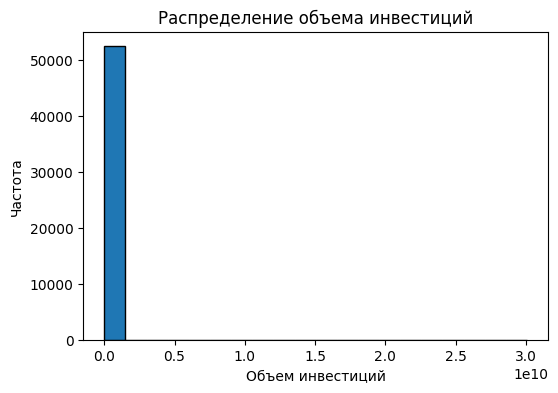

In [1993]:
# Построим гистограмму распределения объема инвестиций
plt.figure(figsize=(6, 4))
plt.hist(df_train['funding_total_usd'], 
         bins=20, 
         edgecolor='black')
plt.xlabel('Объем инвестиций')
plt.ylabel('Частота')
plt.title('Распределение объема инвестиций')
plt.show()

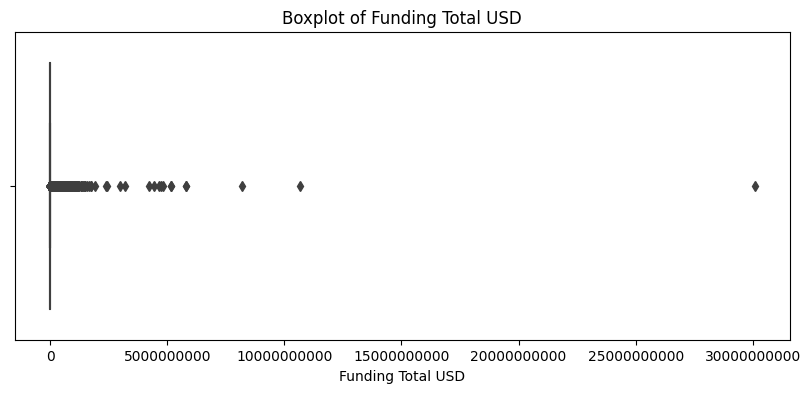

In [1994]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df_train['funding_total_usd'])
plt.ticklabel_format(style='plain', axis='x')  # Отключаем для оси X
plt.xlabel('Funding Total USD')
plt.title('Boxplot of Funding Total USD')
plt.show()

In [1995]:
print(df_train[(df_train['funding_total_usd'] > 1000000000)][['funding_total_usd', 'name']]
      .sort_values(by='funding_total_usd')
      .tail(10)
)

       funding_total_usd                                 name
9343       4,630,000,000                               Suning
37423      4,745,460,219                              Ping An
45915      4,812,000,000                              Alibaba
5287       5,150,000,000  Cambridge Technology Partners (Ctp)
29080      5,162,513,431               Charter Communications
36634      5,800,000,000                             Sberbank
15976      5,820,000,000                            Clearwire
4557       8,207,450,000                                 Uber
21241     10,664,943,639           Cambridge Technology Group
39186     30,079,503,000               Verizon Communications


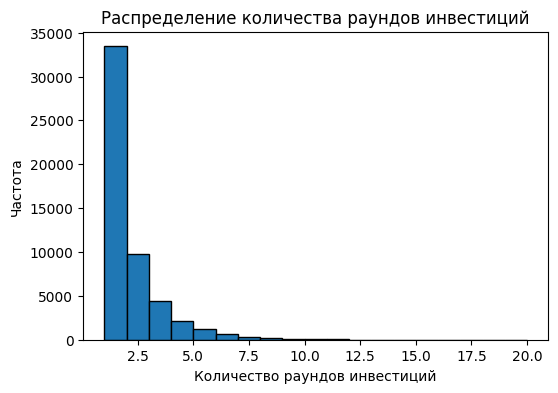

In [1996]:
# Построим гистограмму распределения раундов инвестиций
plt.figure(figsize=(6, 4))
plt.hist(df_train['funding_rounds'], 
         bins=range(1, df_train['funding_rounds'].max() + 2), 
         edgecolor='black')
plt.xlabel('Количество раундов инвестиций')
plt.ylabel('Частота')
plt.title('Распределение количества раундов инвестиций')
plt.show()

### Обрабатываем геополя

In [1997]:
display(df_train.head())

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,"828,626",operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,Earlens,Medical Devices|Medical Devices|Semiconductor ...,"42,935,019",operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology and Semiconductor,"35,456,381",operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio And Company,Health Care,"22,250,000",operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,Wiretough Cylinders,Semiconductor Manufacturing Equipment,0,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


In [1998]:
print(df_train['country_code'].value_counts().head())

country_code
USA    29663
GBR     2919
CAN     1537
IND     1276
CHN     1240
Name: count, dtype: int64


In [1999]:
#print(df_train['region'].value_counts().head(20))
print(df_train['region'].value_counts().head(12))
print('')
print(df_train[df_train['country_code'] != 'USA']['region'].value_counts().head(10))

region
SF Bay Area         6963
New York City       2768
Boston              1889
London              1837
Los Angeles         1510
Seattle              952
Washington, D.C.     817
Chicago              776
San Diego            702
Austin               650
Denver               637
Toronto              588
Name: count, dtype: int64

region
London       1837
Toronto       588
Tel Aviv      571
Paris         543
Beijing       464
Singapore     341
Bangalore     340
New Delhi     287
Shanghai      276
Moscow        265
Name: count, dtype: int64


In [2000]:
# Заполним пропуски в геополях
print(df_train.isna().sum())

df_train['country_code'] = df_train['country_code'].fillna('unknown')
df_train['state_code'] = df_train['state_code'].fillna('unknown')
df_train['region'] = df_train['region'].fillna('unknown')
df_train['city'] = df_train['city'].fillna('unknown')

name                     0
category_list            0
funding_total_usd        0
status                   0
country_code          5486
state_code            6745
region                6343
city                  6343
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47521
dtype: int64


### Обрабатываем поля с датами

In [2001]:
# Приведем колонки к правильным типам
to_datetime64(df_train, ['founded_at', 'first_funding_at', 'last_funding_at'])

In [2002]:
# Сделаем новые колонки с количеством месяцев от начальной даты до события колонки
def transform_age(df, col):
    new_col_name = 'months_since_' + col
    df[new_col_name] = abs(((df[col].dt.year - START_DATE.year) * 12 + (df[col].dt.month - START_DATE.month)))

transform_age(df_train, 'founded_at')
transform_age(df_train, 'first_funding_at')
transform_age(df_train, 'last_funding_at')

In [2003]:
'''
df_train['founded_at_year'] = pd.to_datetime(df_train['founded_at'], errors='coerce').dt.year
df_train['first_funding_at_year'] = pd.to_datetime(df_train['first_funding_at'], errors='coerce').dt.year
df_train['last_funding_at_year'] = pd.to_datetime(df_train['last_funding_at'], errors='coerce').dt.year
df_train['closed_at_year'] = pd.to_datetime(df_train['closed_at'], errors='coerce').dt.year
'''

"\ndf_train['founded_at_year'] = pd.to_datetime(df_train['founded_at'], errors='coerce').dt.year\ndf_train['first_funding_at_year'] = pd.to_datetime(df_train['first_funding_at'], errors='coerce').dt.year\ndf_train['last_funding_at_year'] = pd.to_datetime(df_train['last_funding_at'], errors='coerce').dt.year\ndf_train['closed_at_year'] = pd.to_datetime(df_train['closed_at'], errors='coerce').dt.year\n"

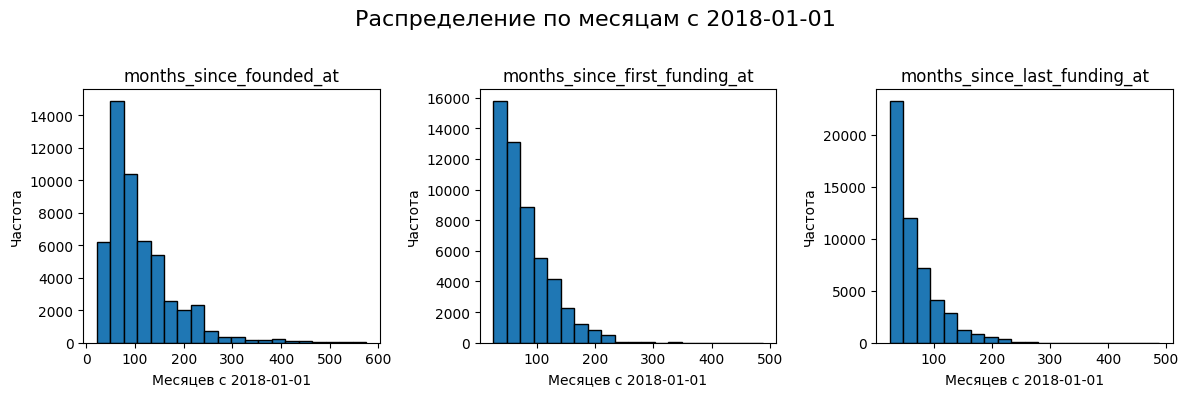

In [2004]:
# Построение гистограмм
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

def render_ax(df, col, n):
    axes[n].hist(df[col], edgecolor='black', bins=20)
    axes[n].set_title(col)
    axes[n].set_xlabel('Месяцев с 2018-01-01')
    axes[n].set_ylabel('Частота')

render_ax(df_train, 'months_since_founded_at', 0)
render_ax(df_train, 'months_since_first_funding_at', 1)
render_ax(df_train, 'months_since_last_funding_at', 2)

fig.suptitle('Распределение по месяцам с 2018-01-01', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

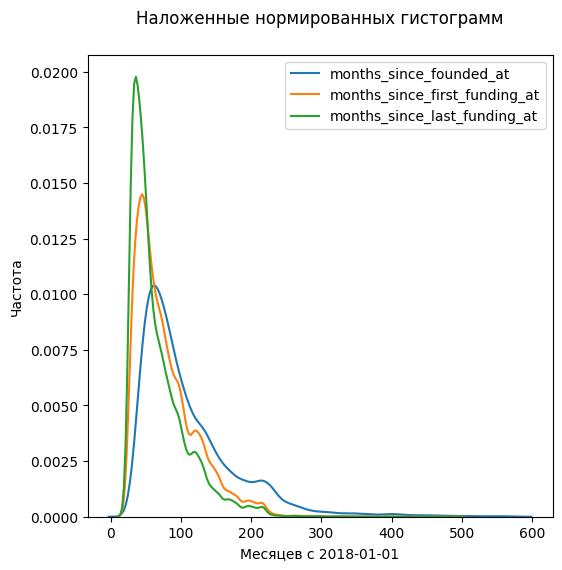

In [2005]:
# Построим нормированные гистограммы по месяцам
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.kdeplot(df_train['months_since_founded_at'], label='months_since_founded_at')
sns.kdeplot(df_train['months_since_first_funding_at'], label='months_since_first_funding_at')
sns.kdeplot(df_train['months_since_last_funding_at'], label='months_since_last_funding_at')

plt.legend()
plt.title('Наложенные нормированных гистограмм', y=1.05)
plt.xlabel('Месяцев с 2018-01-01')
plt.ylabel('Частота')

plt.show()

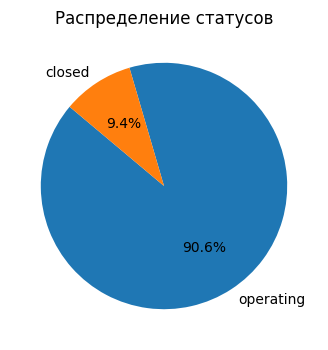

In [2006]:
# Подсчитываем количество каждого статуса
status_counts = df_train['status'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Распределение статусов')
plt.show()

### Изучаем корреляцию признаков (мультиколлинеарность)

In [2007]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52430 entries, 0 to 52515
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   name                           52430 non-null  object        
 1   category_list                  52430 non-null  object        
 2   funding_total_usd              52430 non-null  float64       
 3   status                         52430 non-null  object        
 4   country_code                   52430 non-null  object        
 5   state_code                     52430 non-null  object        
 6   region                         52430 non-null  object        
 7   city                           52430 non-null  object        
 8   funding_rounds                 52430 non-null  int64         
 9   founded_at                     52430 non-null  datetime64[ns]
 10  first_funding_at               52430 non-null  datetime64[ns]
 11  last_funding_at     

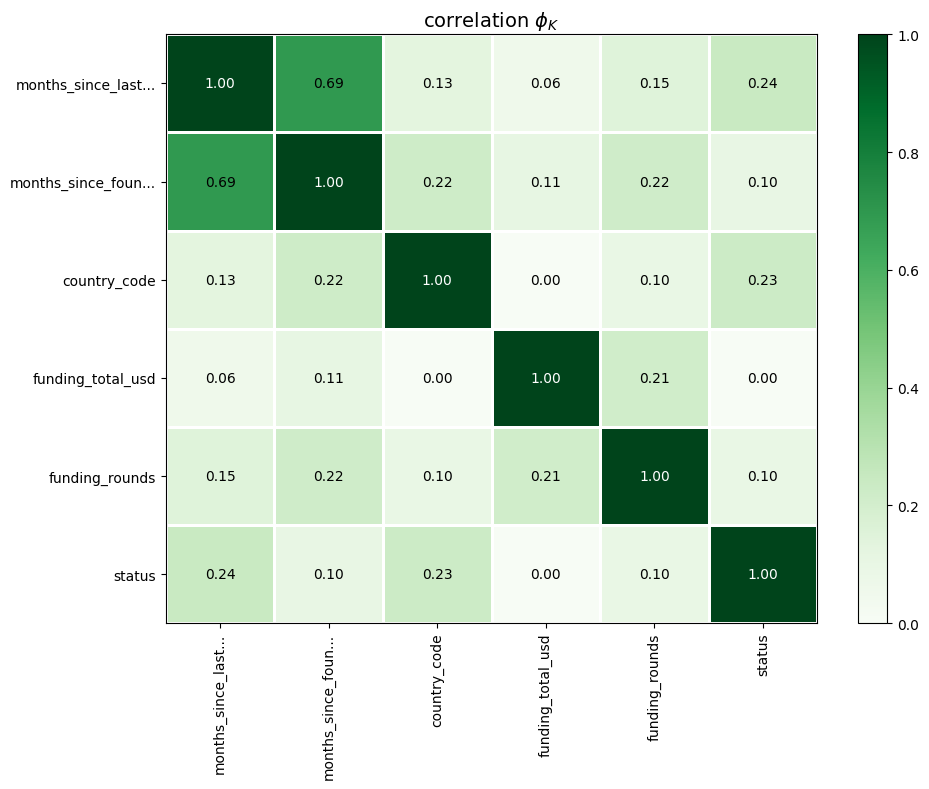

In [2008]:
cols = ['status',
        'funding_rounds',
        'funding_total_usd',
        'country_code',
        'months_since_founded_at',
        #'months_since_first_funding_at',
        'months_since_last_funding_at',
       ]

interval_cols=['funding_rounds',
               'funding_total_usd',
               'months_since_founded_at',
               #'months_since_first_funding_at',
               'months_since_last_funding_at',
              ]

# Вычисляем phik-корреляционную матрицу для выбранных колонок
phik_corr_matrix = df_train[cols].phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(
    phik_corr_matrix.values,
    x_labels=phik_corr_matrix.columns,
    y_labels=phik_corr_matrix.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    figsize=(10, 8)
)

## Работаем с X_test

In [2009]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [2010]:
X_test['category_list'] = X_test['category_list'].fillna('unknown')

# Посчитаем количество уникальных комбинаций
print('Количество уникальных комбинаций категорий:', len(X_test['category_list'].unique()))

# Посчитаем количество уникальных категорий
all_categories = X_test['category_list'].str.split('|').explode().unique()
print('Количество уникальных категорий:', len(all_categories))

Количество уникальных комбинаций категорий: 6207
Количество уникальных категорий: 796


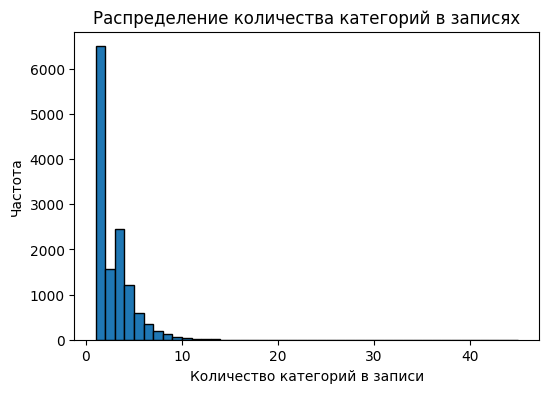

Количество записей с более чем 10 категориями: 60


In [2011]:
# Построим гистограмму распределения количества категорий в каждой записи
category_counts = X_test['category_list'].str.split('|').apply(len)

plt.figure(figsize=(6, 4))
plt.hist(category_counts, bins=range(1, category_counts.max() + 2), edgecolor='black')
plt.xlabel('Количество категорий в записи')
plt.ylabel('Частота')
plt.title('Распределение количества категорий в записях')
plt.show()

print('Количество записей с более чем 10 категориями:', 
      len(X_test[X_test['category_list'].str.split('|').apply(len) > 10])
)

# Заменим значения category_list с более чем 10 категориями на 'multi'
X_test.loc[X_test['category_list'].str.split('|').apply(len) > 10, 'category_list'] = 'multi'

In [2012]:
X_test['category_list'] = X_test['category_list'].apply(to_title_case)

In [2013]:
X_test['category_list'] = X_test['category_list'].apply(remove_duplicates)

In [2014]:
# Разделяем категории на однословные и многословные
one_word_categories = [cat for cat in all_categories if ' ' not in cat]
multi_word_categories = [cat for cat in all_categories if ' ' in cat]

# Создаем словарь для замены: ключи — однословные категории, значения — многословные категории
replacement_dict = {}

for one_word in one_word_categories:
    # Ищем многословные категории, которые содержат однословную категорию
    matching_multi_words = [multi_word for multi_word in multi_word_categories if one_word in multi_word.split()]
    
    # Если есть совпадения, добавляем в словарь первый найденный многословный вариант
    if matching_multi_words:
        replacement_dict[one_word] = matching_multi_words[0]  # или можно добавить все совпадения, если нужно

# Применяем замену к колонке 'category_list'
X_test['category_list'] = X_test['category_list'].apply(replace_single_word_categories)

In [2015]:
# Выводим результат
print('Количество уникальных комбинаций категорий:', len(X_test['category_list'].unique()))

# Посчитаем количество уникальных категорий
all_categories = X_test['category_list'].str.split('|').explode().unique()
print('Количество уникальных категорий:', len(all_categories))

# Выведем примеры категорий
print('')
for category in X_test['category_list'].unique()[:50]:
    print(category)

Количество уникальных комбинаций категорий: 6054
Количество уникальных категорий: 723

Clean Technology
Hospitality
Finance Technology
Hardware + Software|Video Streaming|Video Streaming
Hardware + Software
Product Design|Mobile Games|Entertainment Industry
Biotechnology
Therapeutics|Medical Devices|Health Care
Enterprises|Consulting
Mobile Advertising
Big Data|Online Travel
Telephony|Telecommunications|Saas|Call Center Automation
K-12 Education|Edtech
Virtual Worlds|Mobile Advertising|Video Streaming
Optimization|Mobile Advertising|Mobile Advertising|Mobile Advertising
Location Based Services|Maps
Medical Devices
Business Services|Machine Learning|Artificial Intelligence
Curated Web|Entrepreneur|Radical Breakthrough Startups|Online Travel
Fitness|Hospitals|Health And Wellness
Social Search|Data Mining|Biotechnology|Big Data Analytics|Health Care|Neuroscience
Application Platforms|Digital Media|Comics|Publishing
Communications Infrastructure|Hardware + Software|Internet Marketing
Mobil

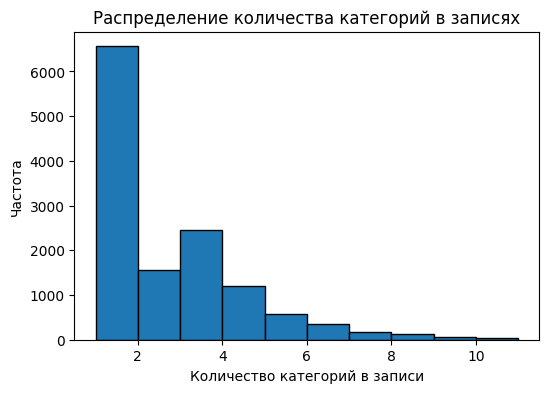

In [2016]:
# Обновим гистограмму распределения количества категорий в каждой записи
category_counts = X_test['category_list'].str.split('|').apply(len)

plt.figure(figsize=(6, 4))
plt.hist(category_counts, 
         bins=range(1, category_counts.max() + 2), 
         edgecolor='black')
plt.xlabel('Количество категорий в записи')
plt.ylabel('Частота')
plt.title('Распределение количества категорий в записях')
plt.show()

In [2017]:
'''
categories_expanded = X_test['category_list'].str.split('|', expand=True)

# Переименовываем колонки
categories_expanded.columns = [f'category_{i+1}' for i in range(categories_expanded.shape[1])]

# Объединяем с исходным DataFrame
X_test = pd.concat([X_test, categories_expanded], axis=1)

# Удаляем исходную колонку 'category_list' (по желанию)
X_test.drop(columns=['category_list'], inplace=True)

cats = ['category_1',
       'category_2',
       'category_3',
       'category_4',
       'category_5',
       'category_6',
       'category_7',
       'category_8',
       'category_9',
       'category_10'
]
       
X_test[cats] = X_test[cats].fillna('unknown')
print(X_test.info())
'''

"\ncategories_expanded = X_test['category_list'].str.split('|', expand=True)\n\n# Переименовываем колонки\ncategories_expanded.columns = [f'category_{i+1}' for i in range(categories_expanded.shape[1])]\n\n# Объединяем с исходным DataFrame\nX_test = pd.concat([X_test, categories_expanded], axis=1)\n\n# Удаляем исходную колонку 'category_list' (по желанию)\nX_test.drop(columns=['category_list'], inplace=True)\n\ncats = ['category_1',\n       'category_2',\n       'category_3',\n       'category_4',\n       'category_5',\n       'category_6',\n       'category_7',\n       'category_8',\n       'category_9',\n       'category_10'\n]\n       \nX_test[cats] = X_test[cats].fillna('unknown')\nprint(X_test.info())\n"

In [2018]:
X_test['funding_total_usd'] = X_test['funding_total_usd'].fillna(0)

In [2019]:
X_test['country_code'] = X_test['country_code'].fillna('unknown')

In [2020]:
# Приведем колонки к правильным типам
to_datetime64(X_test, ['first_funding_at', 'last_funding_at'])

In [2021]:
X_test['lifetime'] = START_DATE - pd.to_timedelta(X_test['lifetime'], unit='days')
X_test = X_test.rename(columns={'lifetime': 'founded_at'})

In [2022]:
transform_age(X_test, 'founded_at')
transform_age(X_test, 'first_funding_at')
transform_age(X_test, 'last_funding_at')

## Обучение модели

In [2023]:
# Готовим датасет для обучения, выделем целевой признак
features = df_train[[
               'name',
#               'category_1',
#               'category_2',
#               'category_3',
#               'category_4',
#               'category_5',
#               'category_6',
#               'category_7',
#               'category_8',
#               'category_9',
#               'category_10',
               'category_list',
               'funding_rounds',
               'funding_total_usd',
               'country_code',
               'months_since_founded_at',
               'months_since_last_funding_at'
              ]]

target = df_train['status']

#ohe_columns = ['category_list', 'name', 'country_code']
ohe_columns = [
               'name',
               'country_code',
               'category_list',
#               'category_1',
#               'category_2',
#               'category_3',
#               'category_4',
#               'category_5',
#               'category_6',
#               'category_7',
#               'category_8',
#               'category_9',
#               'category_10'
]
num_columns = ['funding_rounds', 'funding_total_usd', 'months_since_founded_at', 'months_since_last_funding_at']

In [2024]:
# Разделяем данные на обучающую и тестовую выборки
X_train, X_valid, y_train, y_valid = train_test_split(
    features, 
    target, 
    test_size=0.2,  # 20% на тестовую выборку
    random_state=RANDOM_STATE
)

In [2025]:
# Кодируем целевой признак
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_valid = le.fit_transform(y_valid)

In [2026]:
catboost_model = CatBoostClassifier(
    iterations=1000,
    depth=6,
    learning_rate=0.1,
    eval_metric='F1',
    cat_features=ohe_columns,
    verbose=0
)

catboost_model.fit(X_train, y_train)

In [2027]:
X_test = X_test[[
               'name',
#               'category_1',
#               'category_2',
#               'category_3',
#               'category_4',
#               'category_5',
#               'category_6',
#               'category_7',
#               'category_8',
#               'category_9',
#               'category_10',
               'category_list',
               'funding_rounds',
               'funding_total_usd',
               'country_code',
               'months_since_founded_at',
               'months_since_last_funding_at'
              ]]

In [2030]:
feature_importances = catboost_model.get_feature_importance()
print(feature_importances)

[4.56657437e-04 1.45488423e+01 4.35454141e+00 1.49915287e+01
 1.32939760e+01 1.87244230e+01 3.40862319e+01]


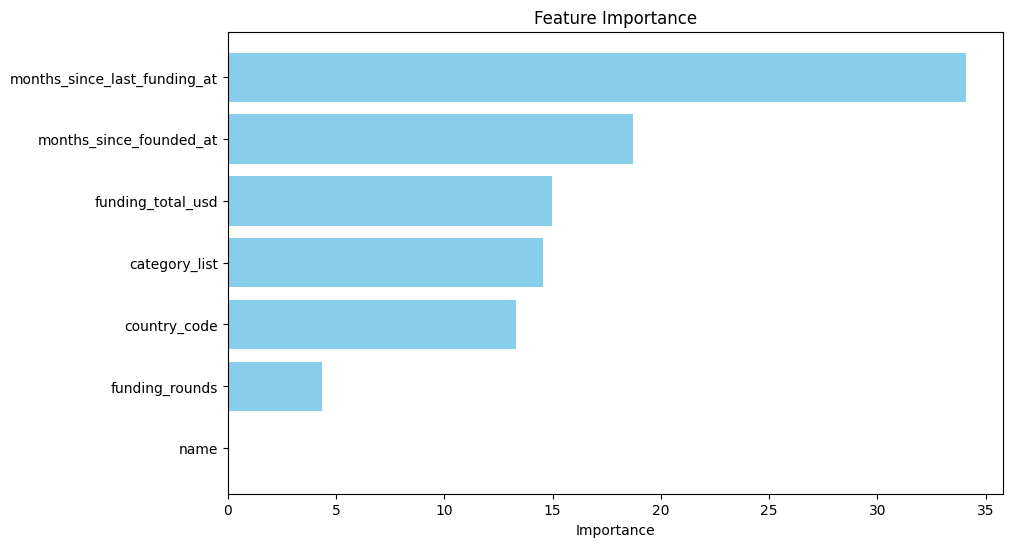

In [2031]:
# Получаем важность признаков
feature_importances = catboost_model.get_feature_importance()

# Создаем DataFrame для визуализации
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Сортируем DataFrame по важности
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# Визуализируем важность признаков
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

In [2032]:
# Предсказываем классы на валидационной выборке
y_pred_valid = catboost_model.predict(X_valid)

# Вычисляем F1-меру
f1 = f1_score(y_valid, y_pred_valid, average='binary') 
print(f'F1 Score: {f1}')

F1 Score: 0.9517464163133454


In [2036]:
# Предсказываем классы на тестовой выборке
y_pred_test = catboost_model.predict(X_test)
print(y_pred_test)

y_pred_test = le.inverse_transform(y_pred_test)

result = pd.DataFrame()
result['name']= X_test['name']
result['pred'] = y_pred_test
display(result)

[1 1 1 ... 1 1 1]


,name,pred
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,operating
...,...,...
13120,Jymob,operating
13121,GlobaTrek,operating
13122,Inkd.com,operating
13123,AdWill,operating


In [2038]:
result.to_csv('da_master_1.csv', index=False, header=True)

In [ ]:
'''
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
#    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('num', MinMaxScaler(), num_columns)
], remainder='passthrough')

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', CatBoostClassifier(
        learning_rate=0.1, 
        iterations=1000, 
#        depth=3, 
        verbose=0,
    ))
])

param_grid = [{
    'iterations': [100, 200, 500, 1000],                   # Количество деревьев (итераций)
    'depth': [4, 6, 8, 10],                                # Глубина деревьев
    'learning_rate': [0.01, 0.05, 0.1, 0.3]                # Скорость обучения
}]

param_grid_full = [
#    {
#        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
#        'models__max_depth': range(3,10),
#        'models__max_features': range(6,12),
#        'models__min_samples_leaf': range(1,10),
#        'preprocessor__num': [MinMaxScaler(), 'passthrough']  
#    },
    {
        'models': [CatBoostClassifier()],
        'models__iterations': [100, 200, 500, 1000],                   # Количество деревьев (итераций)
        'models__depth': [4, 6, 8, 10],                                # Глубина деревьев
        'models__learning_rate': [0.01, 0.05, 0.1, 0.3],               # Скорость обучения
#        'models__l2_leaf_reg': [1, 3, 5, 7, 9],                        # Коэффициент регуляризации L2
#        'models__border_count': [32, 64, 128, 254],                    # Количество разбиений для числовых признаков
#        'models__bagging_temperature': [0.1, 0.5, 1, 2, 5],            # Температура подвыборки (для случайного выбора признаков)
#        'models__random_strength': [1, 2, 5, 10],                      # Сила случайности в выборе признаков
        'models__scale_pos_weight': [1, 2, 5, 10],                     # Балансировка классов для несбалансированных данных
        'models__boosting_type': ['Ordered', 'Plain'],                 # Тип бустинга: Ordered — для несбалансированных данных
        'models__bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],    # Тип подвыборки
#        'models__preprocessor__num': [MinMaxScaler(), 'passthrough']  
    }
]

catboost_model = CatBoostClassifier(
    verbose=0, 
    random_state=RANDOM_STATE
)

search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_grid, 
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=10
)

ohe_columns_features = [X_train.columns.get_loc(col) for col in ohe_columns]
search.fit(X_train, y_train, cat_features=ohe_columns_features)

print('Лучшая модель и её параметры:\n\n', search.best_estimator_)
print('Метрика лучшей модели на кросс-валидации:', (search.best_score_))
'''